## Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Чтобы помочь HR аналитикам построим 2 модели: 
- Первая - модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- вторая — модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача 1: предсказание уровня удовлетворённости сотрудника

## Описание данных

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, **целевой признак.**

## Загрузка данных

In [1]:
!pip install -U scikit-learn -q

In [2]:
!pip install yellowbrick -q

In [3]:
!pip install shap -q

In [4]:
!pip install phik -q

In [5]:
import warnings

warnings.filterwarnings('ignore')

In [6]:
import sklearn
print(sklearn.__version__)

1.4.0


In [7]:
# библиотеки
import phik
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)

from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    fbeta_score,
    roc_curve,
    RocCurveDisplay,
    roc_auc_score,
    ConfusionMatrixDisplay,
    make_scorer
)
from yellowbrick.classifier.rocauc import roc_auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn import svm
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification

In [8]:
# данные
# Тренировочная выборка:
train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
# Входные признаки тестовой выборки:
test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
# Целевой признак тестовой выборки:
target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

## Предобработка данных

### Train

In [9]:
train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [10]:
train.shape

(4000, 10)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [12]:
train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [13]:
train.duplicated().sum()

0

In [14]:
# создадим функцию для проверки неявных дубликатов
def uniq(data):
    x = data.select_dtypes(include='object').columns.tolist()
    for i in x:
        print(i)
        print(data[i].unique())
        print(data[i].nunique())
        print()

In [15]:
uniq(train)

dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
5

level
['junior' 'middle' 'sinior' nan]
3

workload
['medium' 'high' 'low']
3

last_year_promo
['no' 'yes']
2

last_year_violations
['no' 'yes']
2



- явных и неявных дубликтов нет, есть только пропуски. Посмотрим на тестовую выборку и потом удалим пропуски через пайплайн.

### Test

In [16]:
test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [18]:
test.shape

(2000, 9)

In [19]:
test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [20]:
test.duplicated().sum()

0

In [21]:
uniq(test)

dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
6

level
['junior' 'middle' 'sinior' nan]
3

workload
['medium' 'low' 'high' ' ']
4

last_year_promo
['no' 'yes']
2

last_year_violations
['no' 'yes']
2



- явных и неявных дубликтов нет, есть только пропуски.
- **в итоге пропуски в столбцах: dept, level, workload**

### Target

In [22]:
target.head(5)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [23]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [24]:
target.shape

(2000, 2)

In [25]:
target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [26]:
target.duplicated().sum()

0

- пропуски и дубликаты отсутствуют

**Вывод**
- явные и неявные дубликаты отсутвуют вданных    
- есть пропуски и пустые значения в тестовой и тренировочной выборках в столбцах: dept, level, workload
- во всех столбцах правильный тип данных, исправлять ничего не требуется
- в тренировочных данных в 2 раза больше строк чем в тестовых

### Пайплайн для пропусков

In [27]:
test = test.merge(target, on='id', how='right')

In [28]:
columns = train.columns

In [29]:
pipe = Pipeline(
    [
        (
            'simpleImputer_1', 
            SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
        ),
        (
            'simpleImputer_2', 
            SimpleImputer(missing_values=' ', strategy = 'most_frequent')
        )
    ]
)

In [30]:
data_preprocessor = ColumnTransformer(
    [
        ('simpleImputer', pipe, columns)
    ]
)

In [31]:
train = pd.DataFrame(data_preprocessor.fit_transform(train), columns = columns)
test = pd.DataFrame(data_preprocessor.transform(test), columns = columns)

**Избавились от пропусков и прощенных значений**

## Исследовательский анализ данных

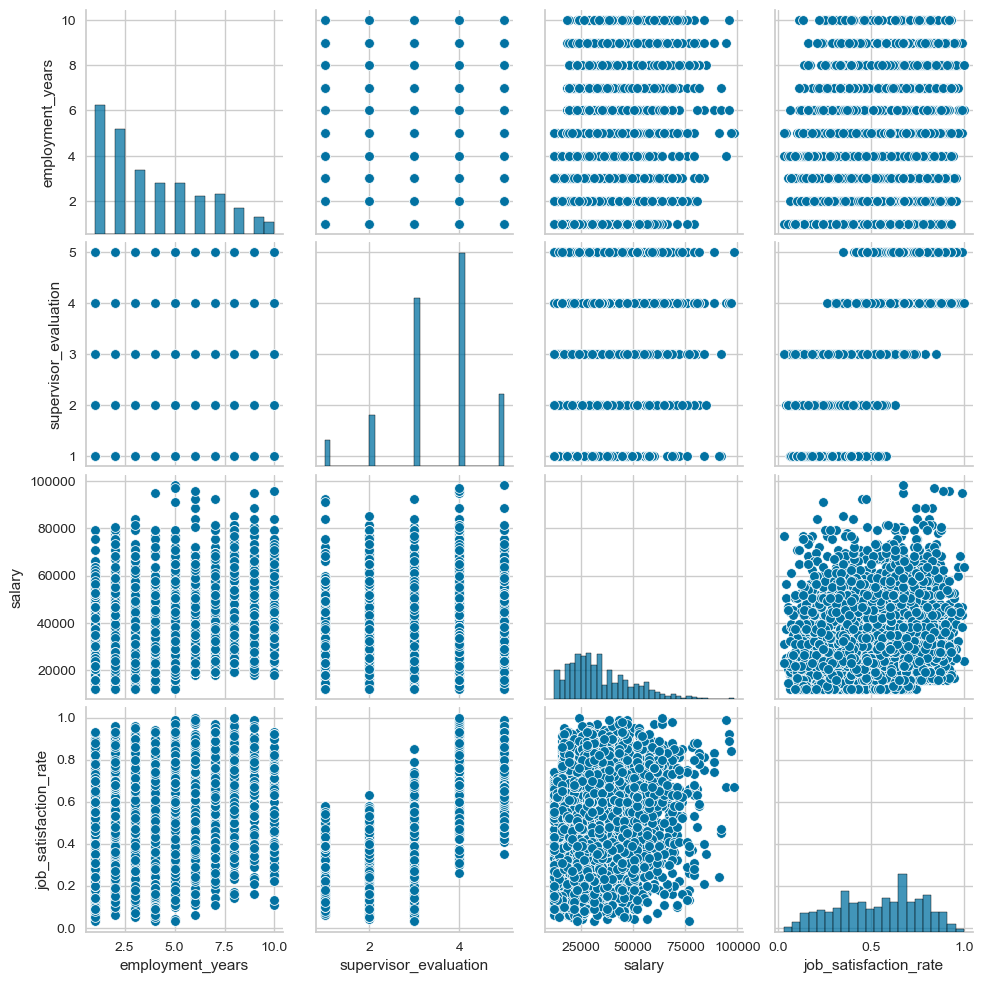

In [32]:
sns.pairplot(train[['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']])
plt.show()

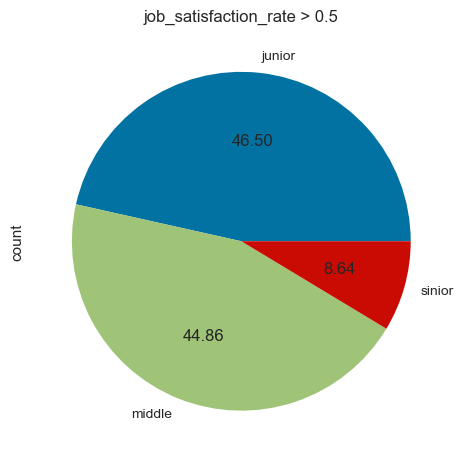

In [33]:
ax1 = train.query('job_satisfaction_rate > 0.5')['level'].value_counts().plot(kind='pie',
        autopct = '%.2f')
ax1.set_title('job_satisfaction_rate > 0.5', fontsize = 12)
plt.show()

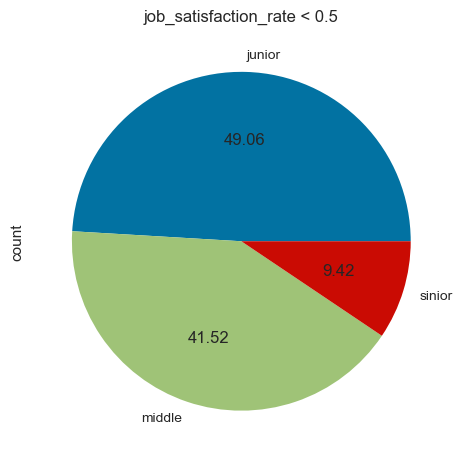

In [34]:
ax2 = train.query('job_satisfaction_rate < 0.5')['level'].value_counts().plot(kind='pie',
        autopct = '%.2f')
ax2.set_title('job_satisfaction_rate < 0.5', fontsize = 12)
plt.show()

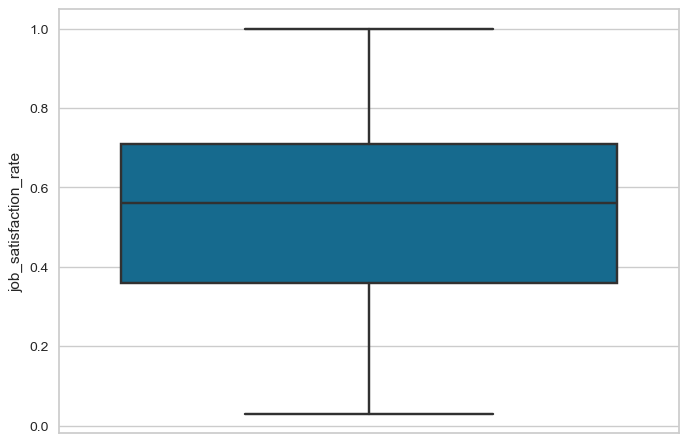

In [35]:
ax = sns.boxplot(y='job_satisfaction_rate', data=train)

**Уровень удовлетворённости в основном лежит в промежутке от 0.4 до 0.7**

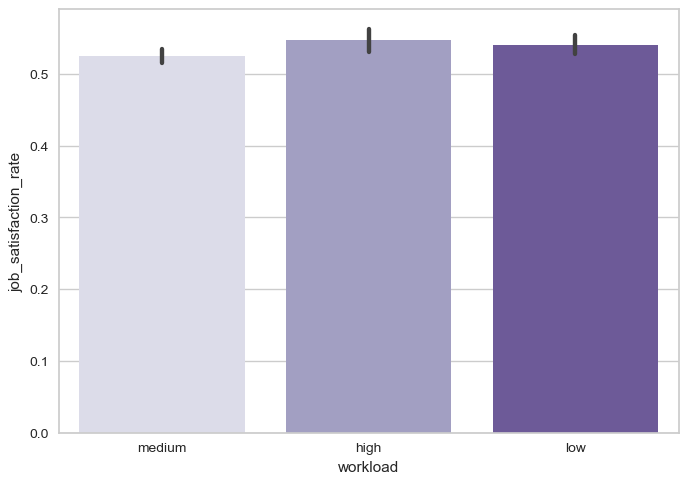

In [36]:
ax = sns.barplot(x='workload', y='job_satisfaction_rate', data=train, palette='Purples')

**Уровень удовлетворённости среди разной загруженности примерно одинаковый**

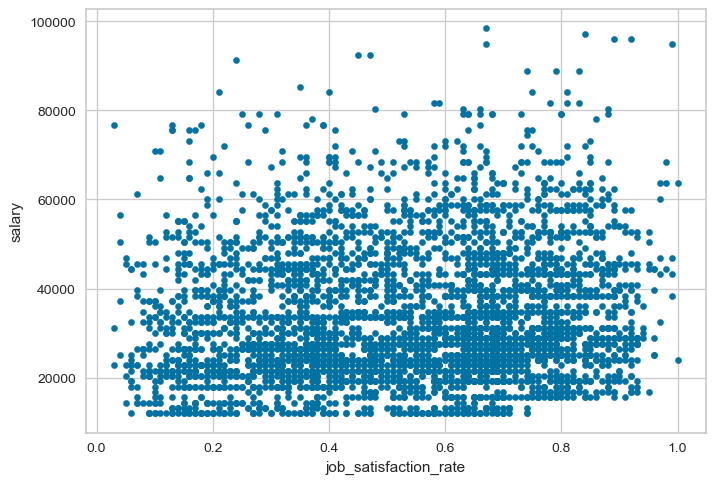

In [37]:
train.plot(x='job_satisfaction_rate',y='salary', kind='scatter')
plt.show()

**Уровень удовлетворённости слабо зависит от зарплаты**

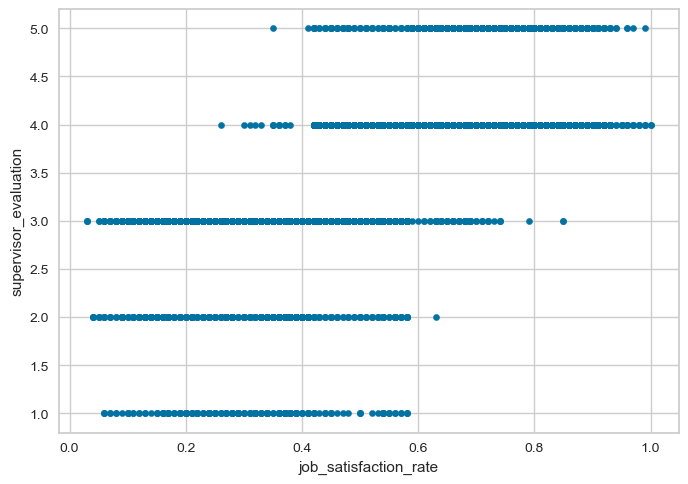

In [38]:
train.plot(x='job_satisfaction_rate', y='supervisor_evaluation', kind='scatter')
plt.show()

**Уровень удовлетворённости сильно зависит от оценки руководителя**

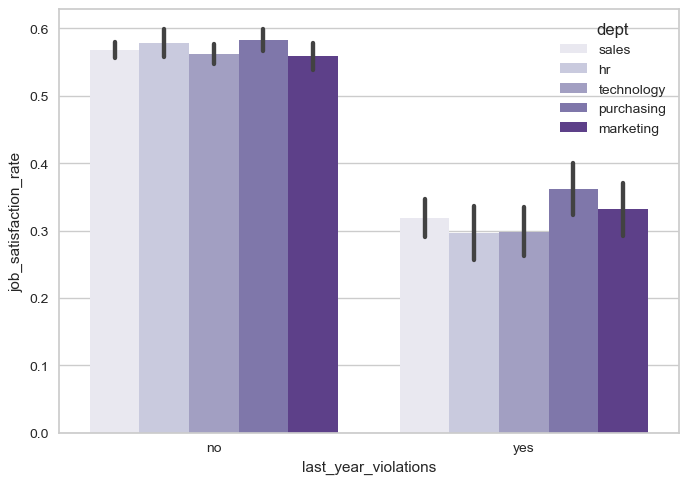

In [39]:
sns.barplot(x='last_year_violations', y='job_satisfaction_rate', hue='dept', data=train, palette='Purples')
plt.show()

**Примерно половина сотрудников нарушала трудовой договор в прошлом году и сотрудников отдела продаж в этом списке было немного больше**

In [40]:
train = train.set_index('id')
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [41]:
train.phik_matrix(interval_cols = interval_cols)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016542,0.036815,0.000000,0.000000,0.105706,0.282657,0.082659
level,0.000000,1.000000,0.419591,0.682962,0.101668,0.000000,0.000000,0.717761,0.080753
workload,0.016542,0.419591,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.036815,0.682962,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101668,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105706,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282657,0.717761,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082659,0.080753,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


- Наблюдается достаточно сильная зависимость между уровнем занимаемой должности и длительностью работы в компании;   между зарплатой и уровнем загруженности
- средняя зависимость между длительностью работы в компании и зарплатой
- также наблюдается зависимость между уровнем занимаемой должности и загруженностью
- **самая сильная и важная для нас зависимость между оценкой качества работы сотрудника, которую дал руководитель и уровенем удовлетворённости сотрудника работой в компании (целевым признаком) = 0.764364**

**Вывод**
- Уровень удовлетворённости в основном лежит в промежутке от 0.4 до 0.7
- Уровень удовлетворённости среди разной загруженности примерно одинаковый
- Уровень удовлетворённости слабо зависит от зарплаты
- Уровень удовлетворённости сильно зависит от оценки руководителя
- Примерно половина сотрудников нарушала трудовой договор в прошлом году и сотрудников отдела продаж в этом списке было немного больше
- Наблюдается достаточно сильная зависимость между уровнем занимаемой должности и длительностью работы в компании;   между зарплатой и уровнем загруженности
- средняя зависимость между длительностью работы в компании и зарплатой
- также наблюдается зависимость между уровнем занимаемой должности и загруженностью
- **самая сильная и важная для нас зависимость между оценкой качества работы сотрудника, которую дал руководитель и уровенем удовлетворённости сотрудника работой в компании (целевым признаком) = 0.764364**

## Подготовка данных

In [42]:
X_train = train.drop(['job_satisfaction_rate'], axis=1)
y_train = train['job_satisfaction_rate']

X_test = test.set_index('id').drop(['job_satisfaction_rate'], axis=1)
y_test = test['job_satisfaction_rate']

In [43]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [44]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [45]:
ord_pipe = Pipeline(
    [
         (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder()
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [46]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [47]:
X_train_processed = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns = data_preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(data_preprocessor.transform(X_test), columns = data_preprocessor.get_feature_names_out())

## Обучение моделей

In [48]:
# итоговый пайплайн: подготовка данных и модель
RANDOM_STATE = 42

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [49]:
def smape(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred) / ((np.abs(y_test) + np.abs(y_pred)) / 2)) * 100

smape_scorer = make_scorer(smape, greater_is_better = False)

In [50]:
param_grid = [
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 40),
        'models__min_samples_leaf': range(2, 13),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()]
    }
]

In [51]:
random = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
random.fit(X_train, y_train)

# Лучшая модель и её параметры
best_params = random.best_params_

y_test_pred = random.best_estimator_.predict(X_test)

 
# Выводим значение SMAPE на тестовой выборке
print ("Метрика SMAPE равна:", smape(y_test, y_test_pred))
print ('Лучшая модель и её параметры:\n', random.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -1* random.best_score_)

Метрика SMAPE равна: 13.688649086910122
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='

**Метрика SMAPE < 15 значит эта модель нам подходит**

In [52]:
y_test_pred =  pd.Series(y_test_pred)

**Вывод**
- Линейная Логистическая и SVC модели сильно хуже DecisionTreeRegressor
- DecisionTreeRegressor показывает хороший результат метрики SMAPE 14.11373373373441 < 15   
  эти результаты подходят под критерии успеха

# Задача 2

## Загрузка данных

In [53]:
# данные
# Тренировочная выборка:
quit_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
# Входные признаки тестовой выборки:
quit_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
# Целевой признак тестовой выборки:
quit_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

## Предобработка данных

### quit_train

In [54]:
quit_train.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no


In [55]:
quit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [56]:
quit_train.shape

(4000, 10)

In [57]:
quit_train.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [58]:
quit_train.duplicated().sum()

0

In [59]:
uniq(quit_train)

dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
5

level
['middle' 'junior' 'sinior']
3

workload
['high' 'medium' 'low']
3

last_year_promo
['no' 'yes']
2

last_year_violations
['no' 'yes']
2

quit
['no' 'yes']
2



### quit_test

In [60]:
quit_test = quit_test.merge(quit_target, on='id', how='right')

In [61]:
quit_test.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,999029,technology,junior,medium,1,no,no,3,31200,yes
1,372846,sales,middle,medium,10,no,yes,2,32400,no
2,726767,marketing,middle,low,7,no,no,4,20400,no


In [62]:
quit_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB


In [63]:
quit_test.shape

(2000, 10)

In [64]:
quit_test.duplicated().sum()

0

In [65]:
quit_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [66]:
uniq(quit_test)

dept
['technology' 'sales' 'marketing' 'purchasing' 'hr' nan ' ']
6

level
['junior' 'middle' 'sinior' nan]
3

workload
['medium' 'low' 'high' ' ']
4

last_year_promo
['no' 'yes']
2

last_year_violations
['no' 'yes']
2

quit
['yes' 'no']
2



### quit_target

In [67]:
quit_target.head(3)

,id,quit
0,999029,yes
1,372846,no
2,726767,no


In [68]:
quit_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [69]:
quit_target.shape

(2000, 2)

In [70]:
quit_target.isna().sum()

id      0
quit    0
dtype: int64

In [71]:
quit_target.duplicated().sum()

0

In [72]:
uniq(quit_target)

quit
['yes' 'no']
2



**Вывод**
- явные и неявные дубликаты отсутвуют вданных    
- есть пропуски и пустые значения в тестовой выборке в столбцах: dept, level, workload
- во всех столбцах правильный тип данных, исправлять ничего не требуется
- в тренировочных данных в 2 раза больше строк чем в тестовых

### Пайплайн для пропусков

In [73]:
columns = quit_train.columns

pipe = Pipeline(
    [
        (
            'simpleImputer_1', 
            SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')
        ),
        (
            'simpleImputer_2', 
            SimpleImputer(missing_values=' ', strategy = 'most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('simpleImputer', pipe, columns)
    ]
)

quit_train = pd.DataFrame(data_preprocessor.fit_transform(quit_train), columns = columns)
quit_test = pd.DataFrame(data_preprocessor.transform(quit_test), columns = columns)

## Исследовательский анализ данных

In [74]:
# возьмём тренировочную выборку, чтобы сделать предсказания уровеня удовлетворённости сотрудника на лучшей модели из задачи 1
X_train_quit = quit_train.set_index('id').drop(['quit'], axis=1)

In [75]:
# предсказанные значения тренировочной выборки
y_train_pred = pd.Series(random.predict(X_train_quit))

In [76]:
# добавим данные в основной датасет
job_prediction_train = pd.DataFrame(pd.concat([
   y_train_pred,
    pd.Series(X_train_quit.index)
], axis=1))
job_prediction_train.columns = ['job_satisfaction_rate', 'id']

quit_train = quit_train.merge(job_prediction_train, on='id')

In [77]:
quit_train = quit_train.set_index('id')

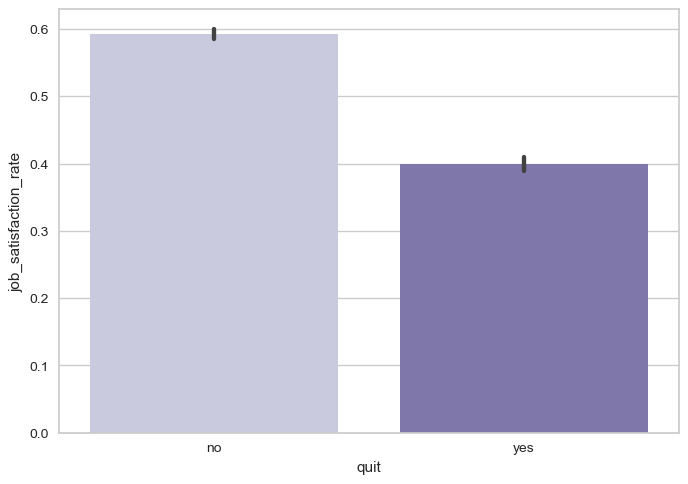

In [78]:
sns.barplot(x='quit', y='job_satisfaction_rate', data=quit_train, palette='Purples')
plt.show()

**У уволившихся сотрудников уровень удовлетворённости ниже 0.4**

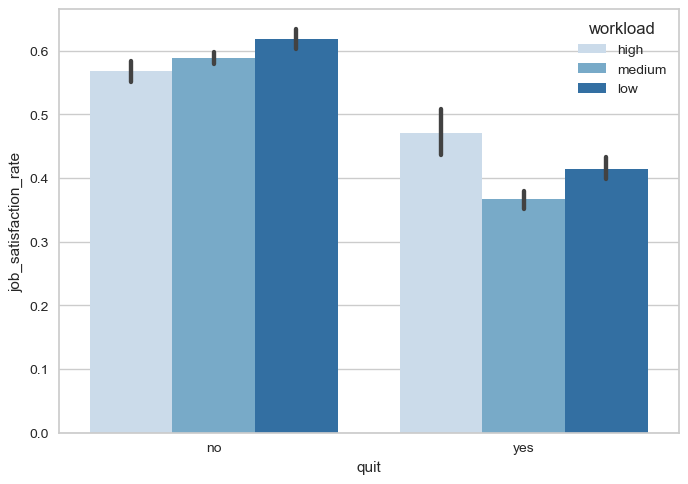

In [79]:
sns.barplot(x='quit', y='job_satisfaction_rate', hue='workload', data=quit_train, palette='Blues')
plt.show()

**У самых неудовлетворённых сотрудников был средний уровень загруженности**

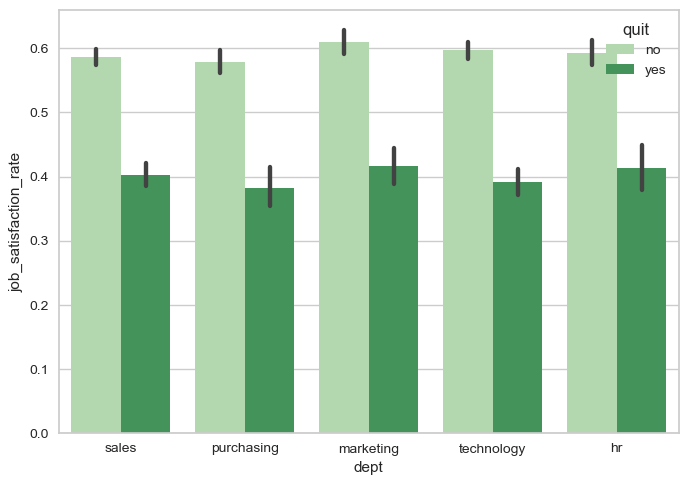

In [80]:
sns.barplot(x='dept', y='job_satisfaction_rate', hue='quit', data=quit_train, palette='Greens')
plt.show()

**У отдела закупок наименьший уровень удовлетворённости**

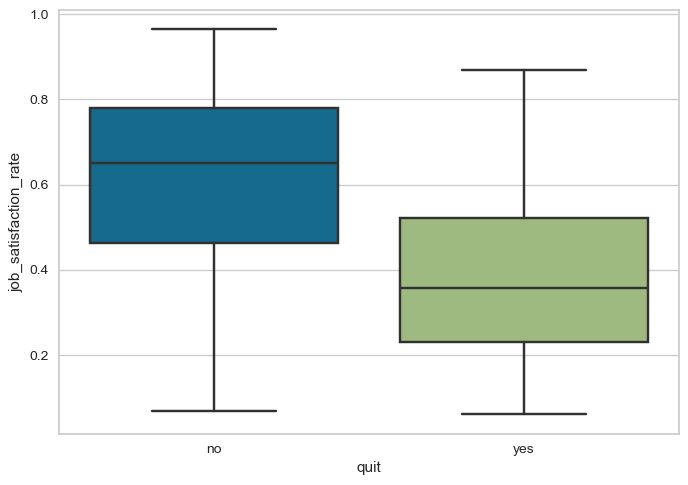

In [81]:
ax = sns.boxplot(x='quit', y='job_satisfaction_rate', data=quit_train)

In [82]:
quit_train['salary'] = pd.to_numeric(quit_train['salary'], errors='coerce')

In [83]:
pivot = quit_train.pivot_table(index='quit', values='salary', aggfunc='mean')
display(pivot.style.format("{:.2f}"))

,salary
quit,
no,37702.23
yes,23885.11


**У уволившихся работников зарплата была значимо ниже**

In [84]:
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

quit_train.phik_matrix(interval_cols = interval_cols)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000,0.241860
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799,0.210076
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243,0.181619
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093,0.431625
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370,0.409814
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071,0.647794
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489,0.782115
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154,0.266530
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000,0.518598
job_satisfaction_rate,0.241860,0.210076,0.181619,0.431625,0.409814,0.647794,0.782115,0.266530,0.518598,1.000000


- Наблюдается достаточно сильная зависимость между уровнем занимаемой должности и длительностью работы в компании;   между зарплатой и уровнем загруженности
- средняя зависимость между длительностью работы в компании и зарплатой
- также наблюдается зависимость между уровнем занимаемой должности и загруженностью
- **достаточно сильная зависимость между уровнем удовлетворённости сотрудника работой в компании с увольнением сотрудника**

In [85]:
# Нулевая гипотеза: среднее значение удовлетворённости сотрудника выше 0.42
# Альтернативная гипотеза: среднее значение удовлетворённости сотрудника ниже 0.42
satisfaction = 0.4

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    quit_train['job_satisfaction_rate'], 
    satisfaction,
      alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('среднее значение удовлетворённости сотрудника ниже 0.42')
else:
    print('среднее значение удовлетворённости сотрудника выше 0.42')

p-значение: 1.0
среднее значение удовлетворённости сотрудника выше 0.42


In [86]:
# Нулевая гипотеза: среднее значение уровня удовлетворённости для не уволившихся и уволившихся сотрудников равны
# Альтернативная гипотеза: среднее значение уровня удовлетворённости для не уволившихся выше
# чем у уволившихся сотрудников 

# задаём уровень значимости
alpha = 0.05

stayed = quit_train.query('quit == "no"')['job_satisfaction_rate']
left = quit_train.query('quit == "yes"')['job_satisfaction_rate']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(stayed, left, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('среднее значение уровня удовлетворённости для не уволившихся выше чем у уволившихся сотрудников ')
else:
    print('среднее значение уровня удовлетворённости для не уволившихся и уволившихся сотрудников равны')

p-value: 1.061720914677906e-152
среднее значение уровня удовлетворённости для не уволившихся выше чем у уволившихся сотрудников 


In [87]:
piv = quit_train.pivot_table(index = 'dept', values = 'quit', aggfunc = 'count')
piv.columns = ['all']
piv_1 = quit_train.query('quit == "yes"').pivot_table(index = 'dept', values = 'quit', aggfunc = 'count')
piv['left'] = piv_1['quit']
piv['fraction'] = piv['left'] / piv['all']
display(piv.style.format("{:.4f}").background_gradient(cmap='Blues', axis=0))

,all,left,fraction
dept,,,
hr,464.0000,116.0000,0.2500
marketing,582.0000,163.0000,0.2801
purchasing,588.0000,166.0000,0.2823
sales,1438.0000,407.0000,0.2830
technology,928.0000,276.0000,0.2974


**Вывод**
- У самых неудовлетворённых сотрудников был средний уровень загруженности
- У отдела закупок наименьший уровень удовлетворённости
- У уволившихся работников зарплата была значимо ниже
- У уволившихся сотрудников уровень удовлетворённости ниже 0.4
- среднее значение удовлетворённости сотрудника выше 0.42
- среднее значение уровня удовлетворённости для не уволившихся выше чем у уволившихся сотрудников 
- наибольшее количество уволившихся в отделе продаж почти с самой высокой долей увольнения
- самая высокая доля увольнения в отделе технологий - 29.74%    

**т.е. стоит обратить внимание на работников отдела технологий с низкой зарплатой и низким уровнем уловлетворённости**

**достаточно сильная зависимость между уровнем удовлетворённости сотрудника работой в компании с увольнением сотрудника, значит добавим его во входные признаки**

## Добавление нового входного признака

In [88]:
# т.к. входные данные тестовой выборки совпадают с задачей 1, то предсказанные значения у нас уже есть - y_test_pred
job_prediction_test = pd.DataFrame(pd.concat([
    y_test_pred,
    pd.Series(X_test.index)
], axis=1))
job_prediction_test.columns = ['job_satisfaction_rate', 'id']

quit_test = quit_test.merge(job_prediction_test, on='id')
quit_test = quit_test.set_index('id')

## Подготовка данных

In [89]:
X_train = quit_train.drop(['quit'], axis=1)
y_train = quit_train['quit']
X_test = quit_test.drop(['quit'], axis=1)
y_test = quit_test['quit']

In [90]:
# ohe_columns # ord_columns  
num_columns.append('job_satisfaction_rate')
num_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [91]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [92]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [93]:
X_train_processed = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns = data_preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(data_preprocessor.transform(X_test), columns = data_preprocessor.get_feature_names_out())

## Обучение моделей

In [94]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [95]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [96]:
ord_pipe = Pipeline(
    [
         (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder()
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [97]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [98]:
# итоговый пайплайн: подготовка данных и модель
RANDOM_STATE = 42

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [99]:


pipe_final.fit(X_train, y_train_encoded)

y_test_pred = pipe_final.predict(X_test)
y_test_proba = pipe_final.predict_proba(X_test)

if roc_auc_score(y_test_encoded, y_test_proba[:, 1]) > 0.91:
    print(f'Метрика ROC-AUC = {roc_auc_score(y_test_encoded, y_test_proba[:, 1])} > 91 \
    что соответствует критерию успеху')
else:
    print('Модель не соответствует критерию успеха')

Метрика ROC-AUC = 0.9202788231691658 > 91     что соответствует критерию успеху


In [100]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [101]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_encoded)

y_test_pred = randomized_search.best_estimator_.predict(X_test)
y_test_proba = randomized_search.best_estimator_.predict_proba(X_test)

print ('Лучшая модель и её параметры:\n', random.best_estimator_)
print ('Метрика лучшей модели на тестовой выборке:', roc_auc_score(y_test_encoded, y_test_proba[:, 1]))

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                      

In [102]:
if roc_auc_score(y_test_encoded, y_test_proba[:, 1]) > 0.91:
    print(f'Метрика ROC-AUC = {roc_auc_score(y_test_encoded, y_test_proba[:, 1])} > 91 \
    что соответствует критерию успеху')
else:
    print('Модель не соответствует критерию успеха')

Метрика ROC-AUC = 0.9179470653311997 > 91     что соответствует критерию успеху


**Вывод**
- лучшая модель - логистическая регрессия
- она справляется лучше из-за простоты, у нас не иак много входных данных и поэтому она обгоняет остальные модели

## Общий вывод

**Задачи**
Построить 2 модели: 
- Первая - модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- вторая — модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Этапы работы**

**задача 1**
- через пайплайн заполнили пропуски и прощенные значения самыми часто встречающимися
- провели исследовательский анализ данных и проверили зависимость признаков от уровня удовлетворённости
- построили модель линейной регрессии и сравнили её с DecisionTreeRegressor для которой подобрали гиперпараметры через RandomSearch.
  Лучшая модель: DecisionTreeRegressor(max_depth=16, max_features=8,
                                       min_samples_leaf=6, random_state=42)
  метрика SMAPE = 14.113733

**задача 2**
- через пайплайн заполнили пропуски и прощенные значения самыми часто встречающимися
- провели исследовательский анализ данных и проверили зависимость признаков от увольнения
- выяснили, что увольнение зависит от уровня удовлетворённости
- лучшая модель - логистическая регрессия   
  Метрика ROC-AUC = 0.920083738 

**Вывод**

В основном у уволившихся сотрудников был средний уровень загруженности и они были из отдела закупок. Также у них была низкая зарплата, что в сумме и уменьшило их удовлетворённость и они уволились.

- Cтоит категориям со средней и высокой загруженностью поднять зарплату.
- Также руководителям стоит быть более лояльными к сотрудникам, чтобы повышалсь их оценка и соответсвенно уровень    
  удовлетворённости (это признак сильно играет роль в их решении об увольнении)